In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
ROOT = '.data'
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.14MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]


In [ ]:
mean = train_data.data.float().mean()/255
std = train_data.data.float().std()/255

In [ ]:
print(f'Calculated mean: {mean}')
print(f'Calculated mean: {std}')

Calculated mean: 0.13066047430038452
Calculated mean: 0.30810779333114624


In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [ ]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)
test_data = datasets.MNIST(root=ROOT,
                          train=False,
                          download=True,
                          transform=train_transforms)

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of training examples: {len(test_data)}')

Number of training examples: 60000
Number of training examples: 10000


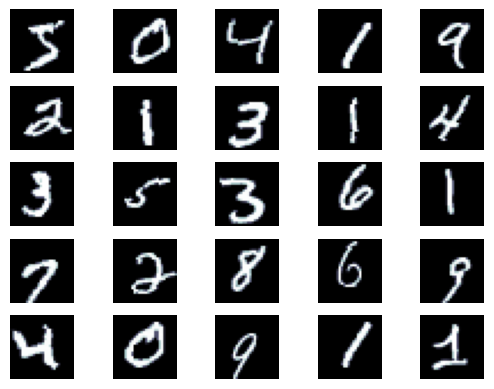

In [ ]:
def plot_images(images):

  n_images = len(images)

  rows=  int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure()
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(images[i].view(28,28).cpu().numpy(),cmap='bone')
    ax.axis('off')
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data)*VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [ ]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


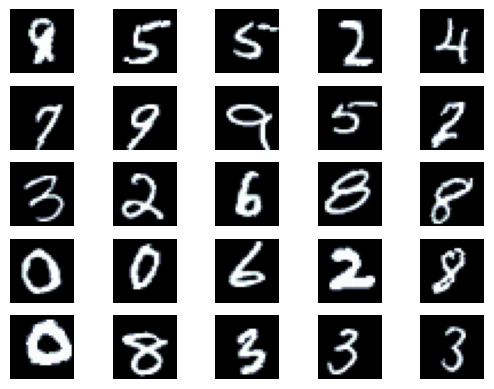

In [ ]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [ ]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()

    self.input_fc = nn.Linear(input_dim,250)
    self.hidden_fc = nn.Linear(250, 100)
    self.output_fc = nn.Linear(100, output_dim)

  def forward(self,x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    h_1 = F.relu(self.input_fc(x))
    h_2 = F.relu(self.hidden_fc(h_1))
    y_pred = self.output_fc(h_2)
    return y_pred, h_2

In [ ]:
INPUT_DIM = 28*28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable paramters')

The model has 222,360 trainable paramters


In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)


In [ ]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argma(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc